# COVID-19 

In this notebook we will go through the developments around the COVID-19 virus infections. First we look at the developments worldwide and finally EU only.

The dataset which I use in this project is provided by the [`European Centre for Disease Prevention and Control (ECDC)`](https://www.ecdc.europa.eu/en/geographical-distribution-2019-ncov-cases)

* Author: Erfan Nariman
* Date: 10-03-2020
* GitHub: [erfannariman](github.com/ErfPy)

---

In [1]:
import pandas as pd
import os
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
pd.set_option('display.max_columns', None)

---

### data import

In [191]:
df = pd.read_excel(os.path.join('..', 'data', 'COVID-19-geographic-disbtribution-worldwide-2020-03-11.xls'))

df.shape

(4729, 7)

---

# Worldwide
Minus China, to get rid of the extreme values for our model later on

### data cleaning

In [192]:
# clean up column names
df.columns = df.columns.str.replace('DateRep', 'Date').str.replace('CountryExp', 'Country')

# convert Date column to datetime type
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

# we filter out China to get rid of the extreme values
china = df.query('Country.eq("China")').copy()
df = df.query('Country.ne("China")')

# replace name to Japan
df['Country'] = df['Country'].str.replace('Cases on an international conveyance Japan', 'Japan')

# print first 5 rows of dataframe
df.head()

,Date,Country,NewConfCases,NewDeaths,GeoId,Gaul1Nuts1,EU
0,2020-03-11,Afghanistan,0,0,AF,NaN,Non-EU/EEA
1,2020-03-11,Afghanistan,3,0,AF,NaN,Non-EU/EEA
2,2020-03-08,Afghanistan,3,0,AF,NaN,Non-EU/EEA
3,2020-03-02,Afghanistan,0,0,AF,NaN,Non-EU/EEA
4,2020-03-01,Afghanistan,0,0,AF,NaN,Non-EU/EEA


### exploratory data analysis (EDA)

In [4]:
# range of data in days
df['Date'].max() - df['Date'].min()

Timedelta('71 days 00:00:00')

In [5]:
# checking for missing days by resampling and checking for NaN
df.set_index('Date').resample('D').mean().isna().sum()

NewConfCases    0
NewDeaths       0
dtype: int64

### which countries had highest new confirmed cases on a day

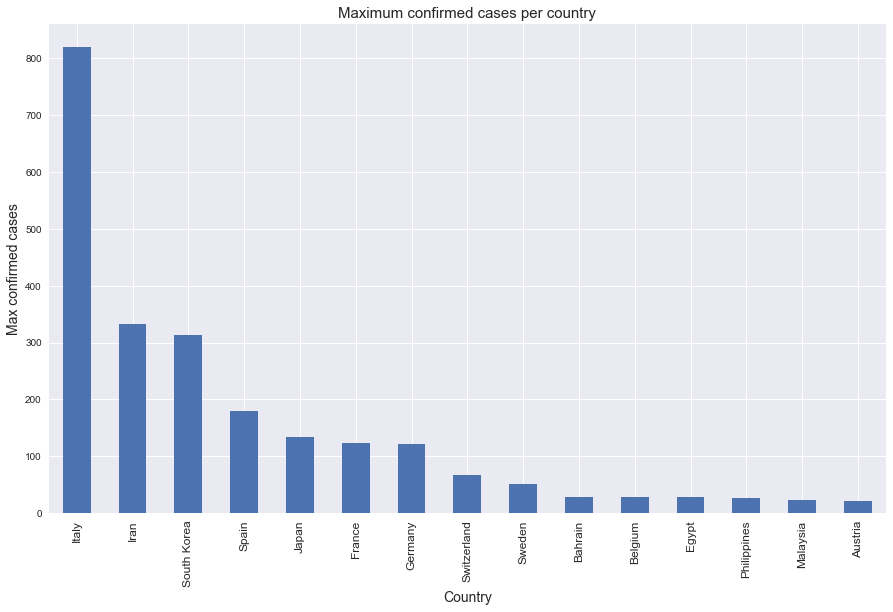

In [78]:
df.groupby('Country')['NewConfCases'].apply(lambda x: x.diff().max()).sort_values(ascending=False).head(15).plot(kind='bar', figsize=(15,9))
plt.xticks(size=12)
plt.ylabel('Max confirmed cases', size=14)
plt.xlabel('Country', size=14)
plt.title('Maximum confirmed cases per country', size=15)
plt.savefig('../plots/plt1.png', dpi=100)
plt.show()

### countries with highest total confirmed cases

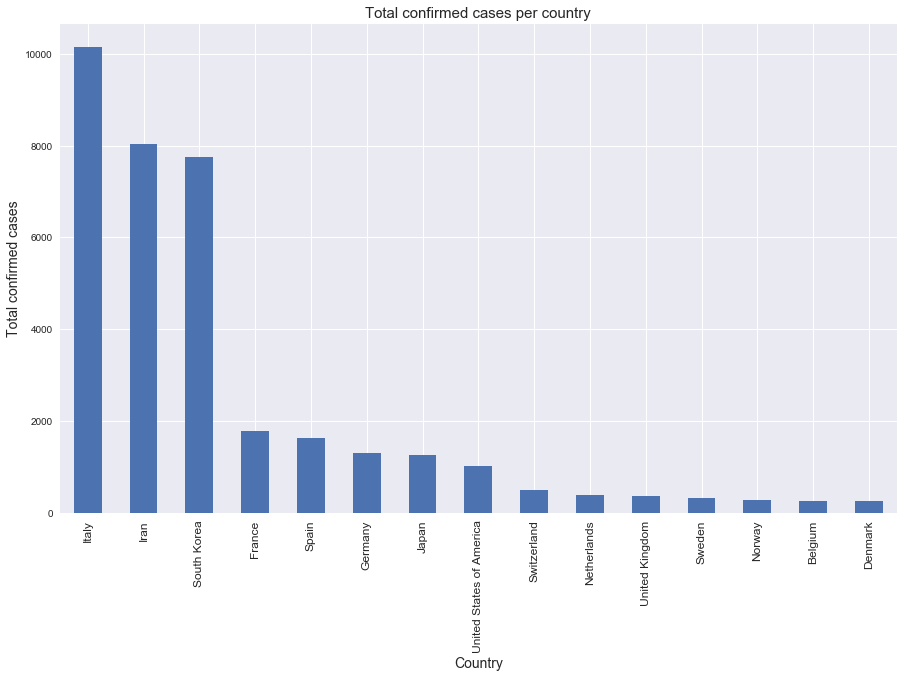

In [59]:
df.groupby('Country')['NewConfCases'].sum().sort_values(ascending=False).head(15).plot(kind='bar', figsize=(15,9))
plt.xticks(size=12)
plt.ylabel('Total confirmed cases', size=14)
plt.xlabel('Country', size=14)
plt.title('Total confirmed cases per country', size=15)
plt.savefig('../plots/plt2.png', dpi=100)
plt.show()

### total amount of confirmed cases over time

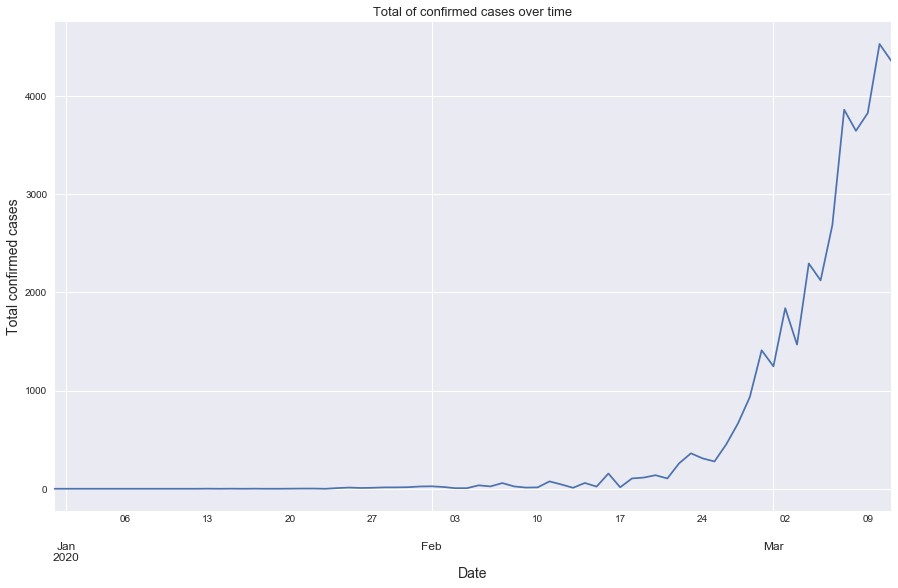

In [61]:
cases_sum = df.groupby('Date')['NewConfCases'].sum()
cases_sum.plot(figsize=(15,9))
plt.xticks(size=12)
plt.ylabel('Total confirmed cases', size=14)
plt.xlabel('Date', size=14)
plt.title('Total of confirmed cases over time', size=15)
plt.savefig('../plots/plt3.png', dpi=100)
plt.show()

### cumulative sum of confirmed cases over time

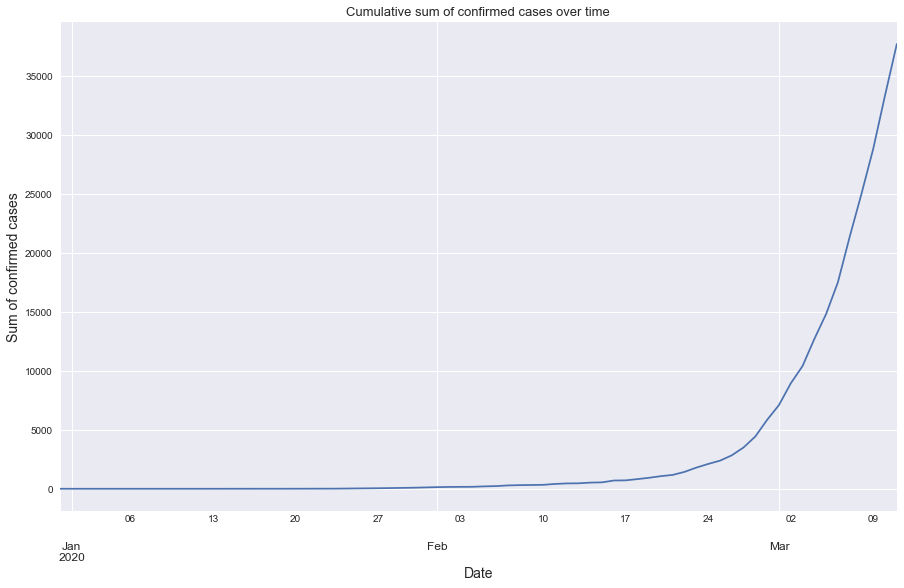

In [62]:
cases_cumsum = cases_sum.cumsum()
cases_cumsum.plot(figsize=(15,9))
plt.xticks(size=12)
plt.ylabel('Sum of confirmed cases', size=14)
plt.xlabel('Date', size=14)
plt.title('Cumulative sum of confirmed cases over time', size=15)
plt.savefig('../plots/plt4.png')
plt.show()

### The log of cumulative sum to check if growth is actually exponential

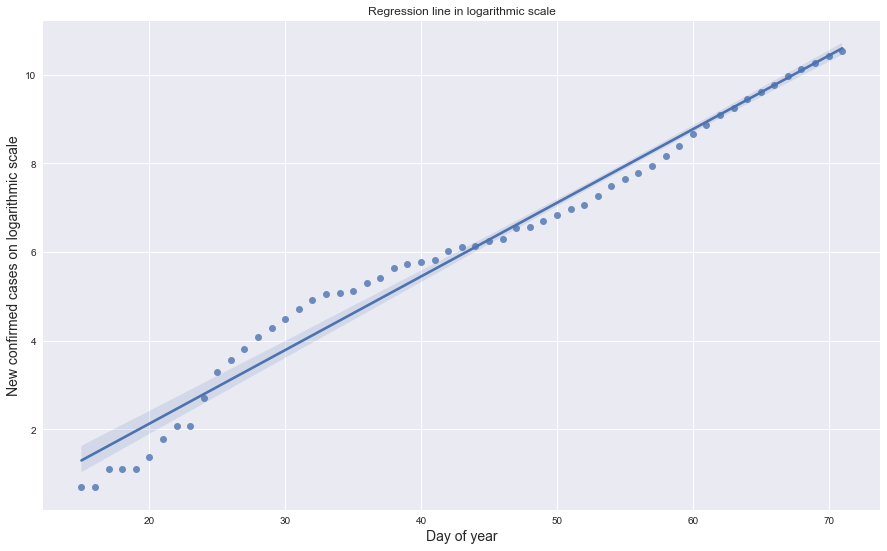

In [63]:
log_cumsum = np.log(cases_cumsum[cases_cumsum.gt(1)]).to_frame().reset_index()
log_cumsum['Date'] = log_cumsum['Date'].dt.dayofyear

plt.figure(figsize=(15,9))
plt.title("Regression line in logarithmic scale", size=15)
sns.regplot(x='Date', y='NewConfCases', data=log_cumsum)
plt.xlabel('Day of year', size=14)
plt.ylabel('New confirmed cases on logarithmic scale', size=14)
plt.savefig('../plots/plt5.png')
plt.show()

### fit a regression line through the log of confirmed cases, this way we can check R^2 

In [9]:
X = log_cumsum['Date']
y = log_cumsum['NewConfCases']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           NewConfCases   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              6583.
Date:                Wed, 11 Mar 2020   Prob (F-statistic):                    9.09e-60
Time:                        14:29:09   Log-Likelihood:                         -52.002
No. Observations:                  57   AIC:                                      106.0
Df Residuals:                      56   BIC:                                      108.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Date           0.1419      0.002     81.134      0.000       0.138       0.145
==============================================================================
Omnibus:                       14.112   Durbin-Watson:                   0.045
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.855
Skew:                          -1.265   Prob(JB):                     0.000361
Kurtosis:                       3.527   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### growth proportion per day, > 1 means we are still in an exponential growth

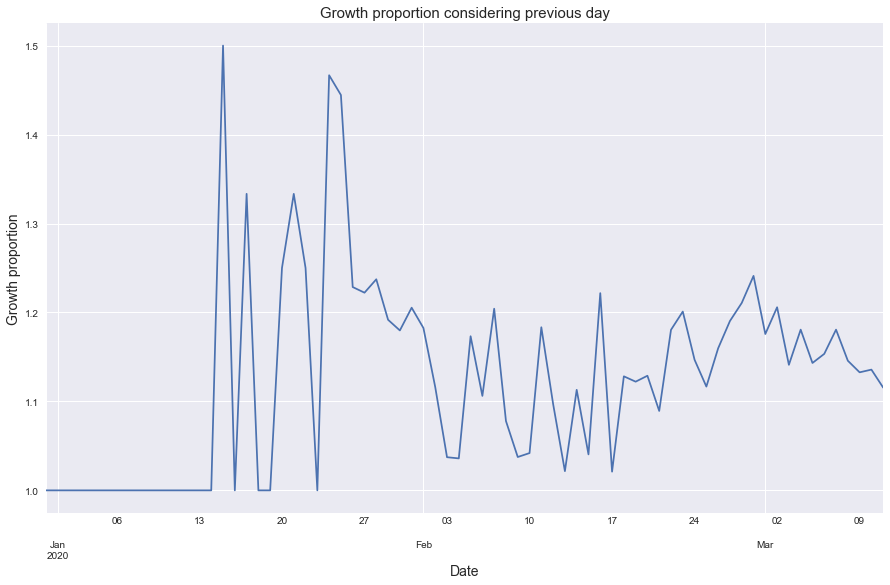

In [66]:
cases_cumsum = cases_cumsum.replace(0, 1)
cases_cumsum.diff().div(cases_cumsum).add(1).fillna(1).plot(figsize=(15,9))

plt.title('Growth proportion considering previous day', size=15)
plt.xlabel('Date', size=14)
plt.ylabel('Growth proportion', size=14)
plt.savefig('../plots/plt6.png')
plt.show()

### time series analysis

In [15]:
from itertools import product

p = d = q = range(0, 2)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]

In [16]:
y = cases_cumsum
y.index = pd.DatetimeIndex(y.index.values,
                           freq=y.index.inferred_freq)

results_list = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            results_list.append((param, param_seasonal, results.aic))
            print(f'ARIMA{param}x{param_seasonal}12 - AIC:{results.aic}')
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1492.8626132501254
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1252.7197721064078
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1238.6485331248477
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:979.7824053230489
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1020.2075328561959
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1001.5456263328042
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:839.3156443319344
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:822.0449815380657
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1421.8731005475393
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1182.1132828917694
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1177.5253918547537
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:938.0223581872218
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:980.0454062394963


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:953.2373090703863
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:808.2202732939811


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:780.4658037601018
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1199.6070781377382
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:998.3307970061061
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:990.1576915982055
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:792.2250647285381
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:914.5393847784246
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:902.0979103031153
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:741.412174549582
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:728.5679791494309
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1109.3378733041252
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:927.8081020356943
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:918.5389652659007
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:735.9395084515077
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:902.8070231061077
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:876.1951840597055
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:732.9148405013685


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:705.905488293409
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:982.09866419348
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:825.1758865926697


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:842.3886329651689
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:693.042104384323
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:800.3579967579234
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:798.4870212196447
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:659.0968177431844


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:653.9203531593624
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:962.6847610661633
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:807.7330020261452
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:823.1651325725111
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:662.1421075794252


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:796.1831222694009


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:785.6974916280046
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:660.8483960868911
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:647.3853277784232
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:957.6898724261574


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:805.8077689415662
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:814.3610253115883


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:659.847019274747
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:800.4410788153369
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:802.4109034732639
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:650.9751770418551
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:652.2939479668116
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:929.5004045529288
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:779.9243017737178
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:791.5955072404469
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:646.9040218043937
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:783.2566114606794


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:797.6297823644464
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:639.4588167215013
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:633.3916156027756


In [17]:
min([aic for x, y, aic in results_list if aic > 0])

633.3916156027756

In [18]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1674      0.020     58.770      0.000       1.128       1.206
ma.L1         -1.1378      0.263     -4.325      0.000      -1.653      -0.622
ar.S.L12      -3.6839      1.283     -2.871      0.004      -6.199      -1.169
ma.S.L12      -0.3228      0.440     -0.733      0.463      -1.186       0.540
sigma2      5.793e+04   3.26e+04      1.777      0.076   -5966.956    1.22e+05


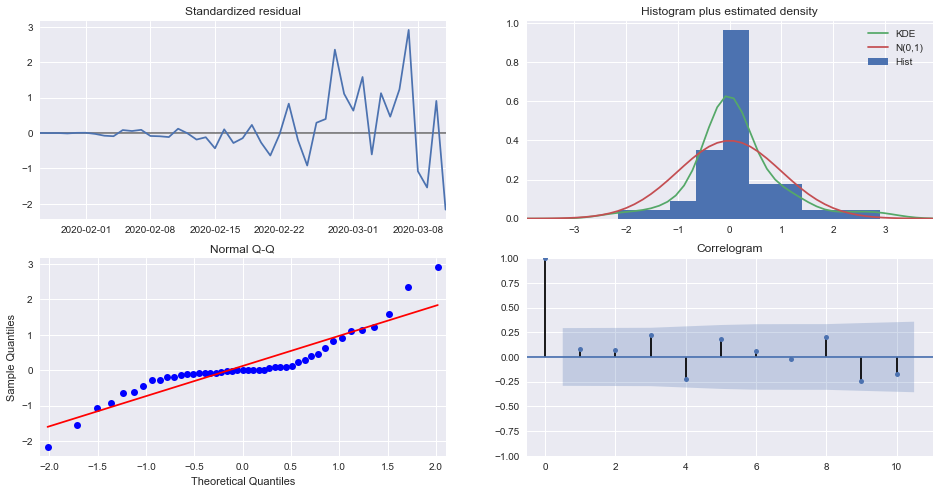

In [19]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('../plots/plt7.png')
plt.show()

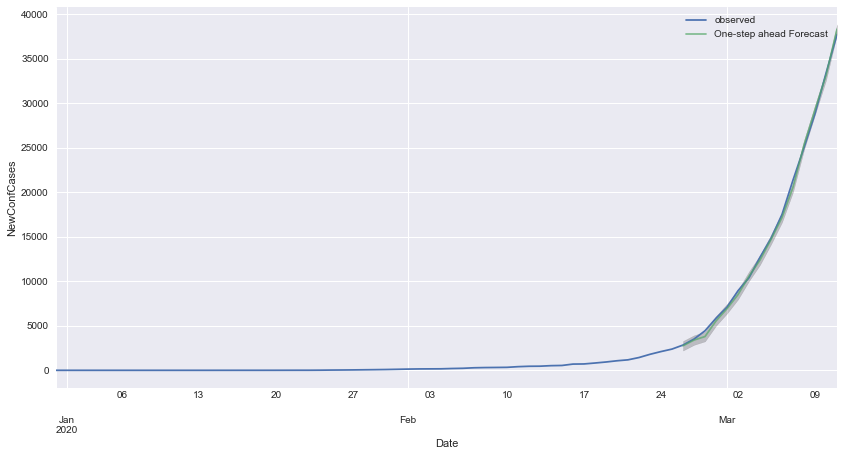

In [20]:
pred = results.get_prediction(start=(y.index.max() - pd.Timedelta(days=14)), dynamic=False)
pred_ci = pred.conf_int()
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('NewConfCases')
plt.legend()
plt.savefig('../plots/plt8.png')
plt.show()

In [96]:
y_forecasted = pred.predicted_mean
y_truth = y[(y.index.max() - pd.Timedelta(days=14)):]
mse = ((y_forecasted - y_truth) ** 2).mean()
print(f'The Mean Squared Error of our forecasts is {round(mse, 2)}')

The Mean Squared Error of our forecasts is 153986.89


In [97]:
print(f'The Root Mean Squared Error of our forecasts is {round(np.sqrt(mse), 2)}')

The Root Mean Squared Error of our forecasts is 392.41


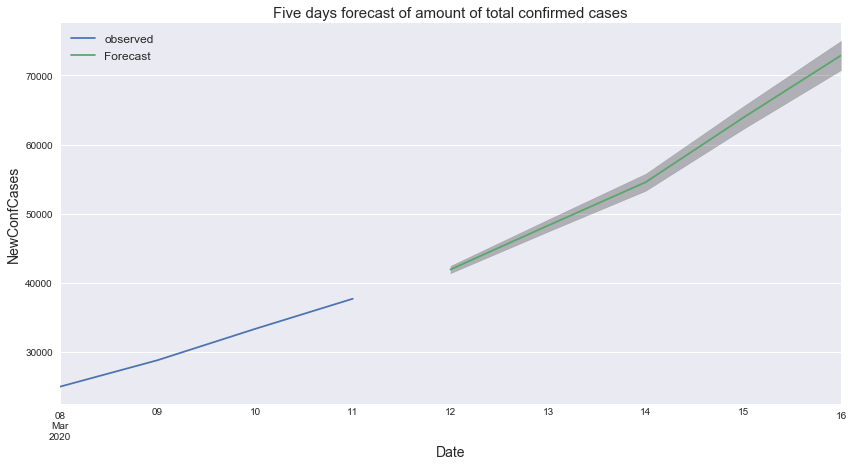

In [74]:
pred_uc = results.get_forecast(steps=5)
pred_ci = pred_uc.conf_int()
ax = y[(y.index.max() - pd.Timedelta(days=3)):].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('NewConfCases', size=14)
plt.legend(fontsize=12)
plt.title('Five days forecast of amount of total confirmed cases', size=15)
plt.savefig('../plots/plt9.png')
plt.show()

# Netherlands

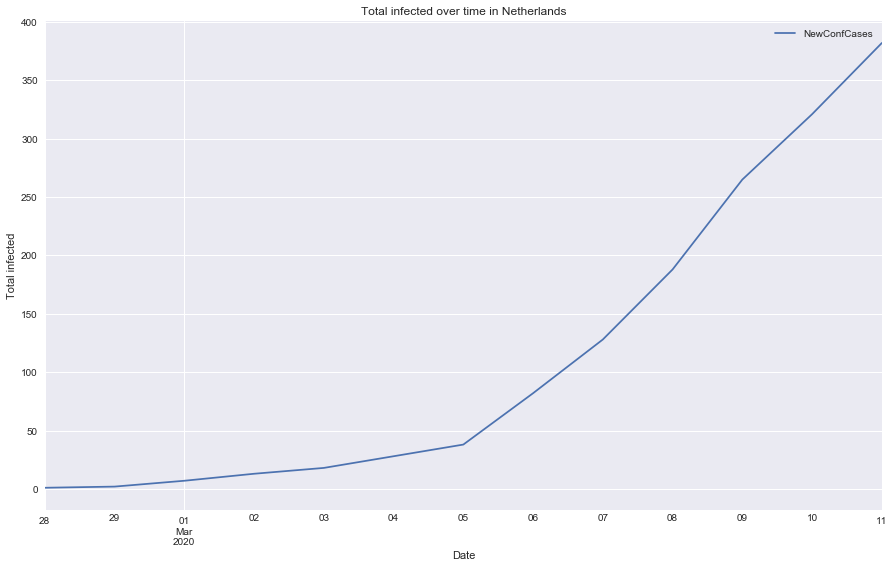

In [235]:
df.query('Country == "Netherlands" & NewConfCases > 0').loc[:, ['Date', 'NewConfCases']].set_index('Date').sort_index().cumsum().plot(figsize=(15,9))
plt.ylabel('Total infected')
plt.title('Total infected over time in Netherlands')
plt.savefig('../plots/NL1.png')
plt.show()

In [233]:
df.query('Country == "Netherlands" & NewConfCases > 0')

,Date,Country,NewConfCases,NewDeaths,GeoId,Gaul1Nuts1,EU
3011,2020-03-11,Netherlands,61,1,NL,NaN,EU
3012,2020-03-10,Netherlands,56,0,NL,NaN,EU
3013,2020-03-09,Netherlands,77,2,NL,NaN,EU
3014,2020-03-08,Netherlands,60,0,NL,NaN,EU
3015,2020-03-07,Netherlands,46,1,NL,NaN,EU
3016,2020-03-06,Netherlands,44,0,NL,NaN,EU
3017,2020-03-05,Netherlands,10,0,NL,NaN,EU
3018,2020-03-04,Netherlands,10,0,NL,NaN,EU
3019,2020-03-03,Netherlands,5,0,NL,NaN,EU
3020,2020-03-02,Netherlands,6,0,NL,NaN,EU


In [194]:
china = china.set_index('Date').sort_index()

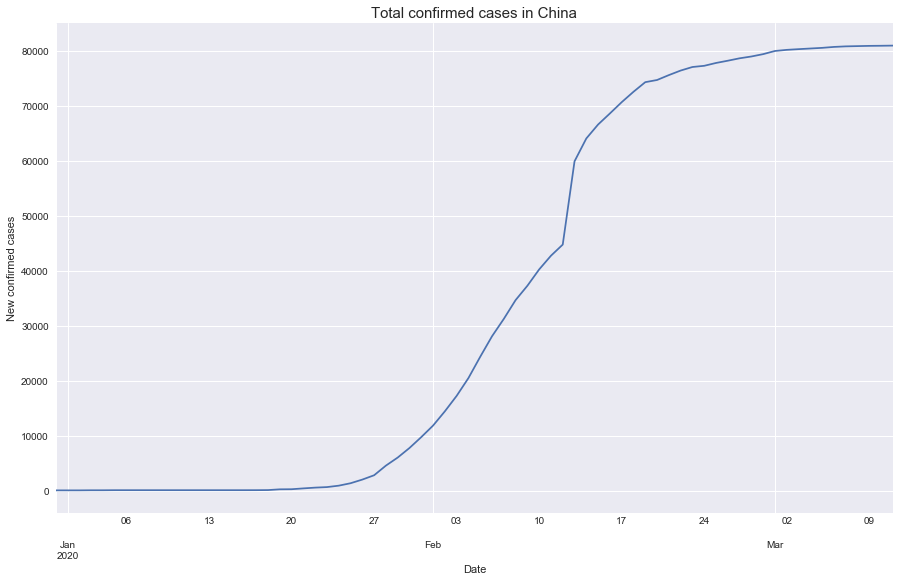

In [195]:
china['NewConfCases'].cumsum().plot(figsize=(15,9))
plt.ylabel('New confirmed cases')
plt.title('Total confirmed cases in China', size=15)
plt.savefig('../plots/china1.png')
plt.show()

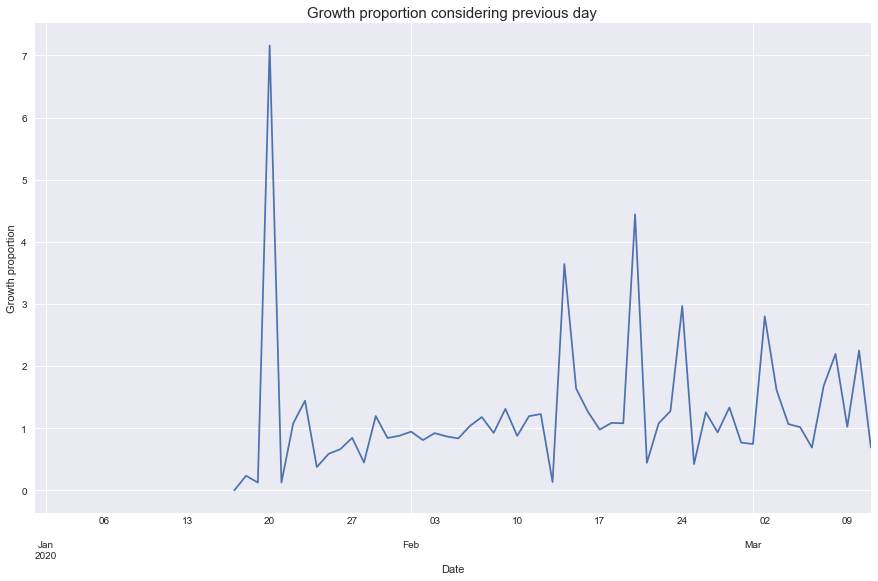

In [236]:
china['NewConfCases'].shift().div(china['NewConfCases']).plot(figsize=(15,9))
plt.ylabel('Growth proportion')
plt.title('Growth proportion considering previous day', size=15)
plt.savefig('../plots/china1.png')
plt.show()